### Datasets
    - gdsc --> gg
    - ctrp --> cc
### Models
    - lgb
    - nn0
    - nn1

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from load_modules import *
%matplotlib inline
fpath = Path(os.getcwd())
print('Current path:', fpath)

## Path to data

In [3]:
method = 'ls_hpo'

In [4]:
fname = 'all_scores.csv'
# dpath = Path('../lc.out.summit.July2020/exp1_scores')
# dpath = Path('../lc.out.summit.July2020/exp_1_and_2')
# dpath = Path('../lc.out.new.r2fit_03/')

# dirs = glob(str(dpath/'*'))
# print(dirs)

In [5]:
# src = 'GDSC1'
# src = 'GDSC2'
# src = 'CTRP'
src = 'NCI60'

if src == 'GDSC1':
    dpath = Path('../lc.out.new.r2fit_03/')
    nn0_path = Path(dpath, f'lc.gdsc1.nn_reg0.{method}', fname)
    nn1_path = Path(dpath, f'lc.gdsc1.nn_reg1.{method}', fname)
    # nn0_path = Path(dpath, f'lc.gdsc1.nn_reg00.{method}', fname)
    # nn1_path = Path(dpath, f'lc.gdsc1.nn_reg11.{method}', fname)
    lgb_path_hpo = Path(dpath, f'lc.gdsc1.lgb.{method}', fname)
#     lgb_path_hpo = None
    lgb_path_dft = None

if src == 'GDSC2':
    dpath = Path('../lc.out.new.r2fit_03/')
    nn0_path = Path(dpath, f'lc.gdsc2.nn_reg0.{method}', fname)
    nn1_path = Path(dpath, f'lc.gdsc2.nn_reg1.{method}', fname)
    lgb_path_hpo = Path(dpath, f'lc.gdsc2.lgb.{method}', fname)
    lgb_path_dft = None

if src == 'CTRP':
    dpath = Path('../lc.out.new.r2fit_03/')
    nn0_path = Path(dpath, f'lc.ctrp.nn_reg0.{method}', fname)
    nn1_path = Path(dpath, f'lc.ctrp.nn_reg1.{method}', fname)
    lgb_path_hpo = Path(dpath, f'lc.ctrp.lgb.{method}', fname)
    # lgb_path_hpo = Path('../lc.out.ctrp.lgb/lc.ctrp.lgb.ls_hpo', fname)
    # nn0_path = None
    # nn1_path = None
    # lgb_path_hpo = None
    # lgb_path_dft = Path('../lc.out.ctrp.lgb/lc.ctrp.lgb.dflt', fname)
    lgb_path_dft = None

if src == 'NCI60':
    dpath = Path('../lc.out.summit.July2020/exp_1_and_2')
    nn0_path = Path(dpath, f'lc.nci60.nn_reg0.random.{method}', fname)
    nn1_path = Path(dpath, f'lc.nci60.nn_reg1.random.{method}', fname)
    lgb_path_hpo = Path('../lc.out.nci60.lgb/lc.nci60.lgb.ls_hpo', fname)
    # nn0_path = None
    # nn1_path = None
    # lgb_path_hpo = None
    lgb_path_dft = None
    # lgb_path_dft = Path('../lc.out.nci60.lgb/lc.nci60.lgb.dflt', fname)
    # lgb_path_dft = Path('../lc.out.nci60.lgb/lc.nci60.lgb.dflt.full', fname)

In [6]:
outpath = fpath/f'summit_fits_{src}'
os.makedirs(outpath, exist_ok=True)

## Load data

In [7]:
nn0 = load_data(nn0_path, tr_set='te');
nn1 = load_data(nn1_path, tr_set='te');
lgb_hpo = load_data(lgb_path_hpo, tr_set='te');
lgb_dft = load_data(lgb_path_dft, tr_set='te');

In [8]:
# print_count(aa=nn0)
# print_count(aa=nn1)
# print_count(aa=lgb_hpo)
# print_count(aa=lgb_dft)

,tr_size,one
0,1024,20
1,1169,20
2,1334,20
3,1523,20
4,1739,20
5,1985,20
6,2267,20
7,2588,20
8,2954,20
9,3373,20


In [54]:
nn0 = drop_bad_r2(nn0)
nn1 = drop_bad_r2(nn1)
lgb_hpo = drop_bad_r2(lgb_hpo)
lgb_dft = drop_bad_r2(lgb_dft)

(5280, 8)
(5280, 9)
(4500, 8)
(4500, 9)
(10000, 5)
(10000, 6)


In [55]:
def calc_gof(y, yfit):
    from sklearn import metrics
    gof = {}
    rmse = sqrt( metrics.mean_squared_error(y, yfit) )
    mae = metrics.mean_absolute_error(y, yfit)
    gof['rmse'] = rmse
    gof['mae'] = mae
    return gof

In [56]:
# NCI60: remove bad samples
if src == 'NCI60':
    # np.unique(sorted(nn0.tr_size))
    nn0 = nn0[ ~nn0['tr_size'].isin([369806, 499618, 580947, 610743, 625000]) ].reset_index(drop=True)
    nn1 = nn1[ ~nn1['tr_size'].isin([369806, 499618, 580947, 610743, 625000]) ].reset_index(drop=True)

## Raw plots

In [57]:
# Global plotting params
# -------------------------------
met = 'mean_absolute_error';  # startParams = {'a': 1.2, 'b': -0.4, 'c': 0.04}
# met = 'mcc';  # startParams = {'a': 1.2, 'b': 0.4, 'c': 0.8}

t_set = 'te'
xtick_scale = 'log2'
ytick_scale = 'log2'
# xtick_scale = 'log10'
# ytick_scale = 'log10'
# xtick_scale = 'linear'
# ytick_scale = 'linear'

kwargs = {'metric_name': met,
          'tr_set': t_set,
          'xtick_scale': xtick_scale,
          'ytick_scale': ytick_scale,
          'plot_median': True}

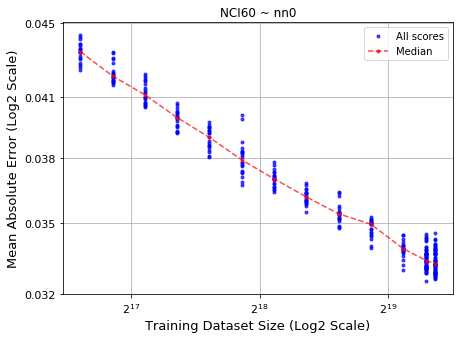

In [58]:
# Plot nn0
# -------------------------------
if nn0 is not None:
    kwargs.update({'title': f'{src} ~ nn0'})
    ax = lc_plots.plot_lc_single_metric(nn0, **kwargs);
    ax.legend(frameon=True, fontsize=10, loc='best')

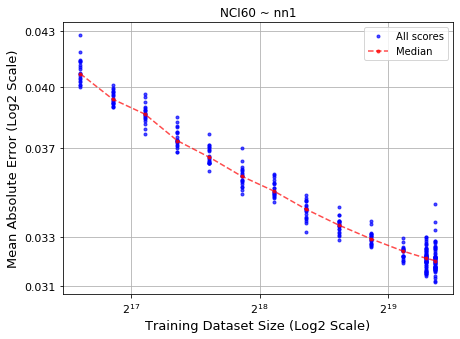

In [59]:
# Plot nn1
# -------------------------------
if nn1 is not None:
    kwargs.update({'title': f'{src} ~ nn1'})
    ax = lc_plots.plot_lc_single_metric(nn1, **kwargs);
    ax.legend(frameon=True, fontsize=10, loc='best')

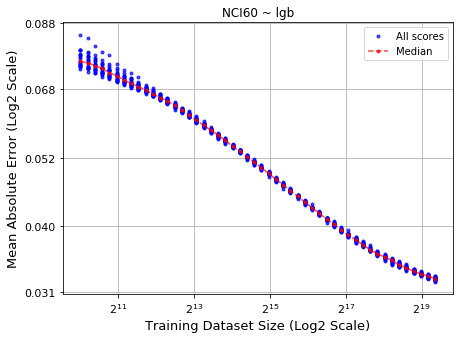

In [60]:
# Plot lgb_hpo
# -------------------------------
if lgb_hpo is not None:
    kwargs.update({'title': f'{src} ~ lgb'})
    ax = lc_plots.plot_lc_single_metric(lgb_hpo, **kwargs);
    ax.legend(frameon=True, fontsize=10, loc='best')

In [61]:
# Plot lgb_hpo
# -------------------------------
if lgb_dft is not None:
    kwargs.update({'title': f'{src} ~ lgb'})
    ax = lc_plots.plot_lc_single_metric(lgb_dft, **kwargs);
    ax.legend(frameon=True, fontsize=10, loc='best')

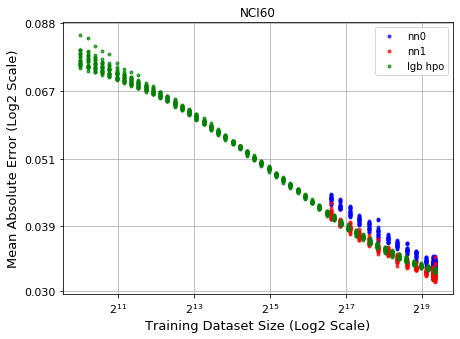

In [62]:
# Plot
# -------------------------------
ax = None
kwargs = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale}

if nn0 is not None:
    nn0 = nn0[nn0.metric==met].reset_index(drop=True)
    ax = lc_plots.plot_lc(x=nn0['tr_size'].values, y=nn0['score'].values, color='b', label='nn0', **kwargs, ax=ax);

if nn1 is not None:
    nn1 = nn1[nn1.metric==met].reset_index(drop=True)
    ax = lc_plots.plot_lc(x=nn1['tr_size'].values, y=nn1['score'].values, color='r', label='nn1', **kwargs, ax=ax);

if lgb_hpo is not None:
    lgb = lgb_hpo
    lgb = lgb[lgb.metric==met].reset_index(drop=True)
    ax = lc_plots.plot_lc(x=lgb['tr_size'].values, y=lgb['score'].values, color='g', label='lgb hpo', **kwargs, ax=ax);
    del lgb
    
if lgb_dft is not None:
    lgb = lgb_dft
    lgb = lgb[lgb.metric==met].reset_index(drop=True)
    ax = lc_plots.plot_lc(x=lgb['tr_size'].values, y=lgb['score'].values, color='m', label='lgb dflt', **kwargs, ax=ax);
    del lgb
    
ax.set_title(f'{src}');
ax.legend(frameon=True, fontsize=10, loc='best')

In [63]:
# nn0[nn0.tr_size == nn0.tr_size.max()].score.values
# nn1[nn1.tr_size == nn1.tr_size.max()].score.values

## Fitting

In [64]:
def fit_data(df, x_fit_mn=0, x_fit_mx=None):
    if df is None:
        return None
    
    df = df[ df['metric']==met ].reset_index(drop=True)
    df['y'] = df['score']
    df = df[df['metric']==met].groupby('tr_size').agg({'y': 'median'}).reset_index()
    
    dfit = subset_data(df, col='tr_size', x_mn=x_fit_mn, x_mx=x_fit_mx)
    dfit = add_weight_col( dfit, binomial=False )
    return dfit

In [65]:
# Split dfit and dext
if src == 'CTRP':
    x_fit_mn = 10000; x_fit_mx = None
    startParams = {'a': 1.2, 'b': -0.3, 'c': 0.04}
elif src == 'GDSC1':
    x_fit_mn = 10000; x_fit_mx = None
    startParams = {'a': 1.2, 'b': -0.3, 'c': 0.04}
elif src == 'GDSC2':
    x_fit_mn = 10000; x_fit_mx = None
    startParams = {'a': 1.2, 'b': -0.3, 'c': 0.04}
elif src == 'NCI60':    
    x_fit_mn = 2**15; x_fit_mx = None
    startParams = {'a': 1.2, 'b': -0.3, 'c': 0.04}

dfit_nn0 = fit_data(nn0, x_fit_mn=x_fit_mn, x_fit_mx=x_fit_mx)
dfit_nn1 = fit_data(nn1, x_fit_mn=x_fit_mn, x_fit_mx=x_fit_mx)
dfit_lgb_hpo = fit_data(lgb_hpo, x_fit_mn=x_fit_mn, x_fit_mx=x_fit_mx)
dfit_lgb_dft = fit_data(lgb_dft, x_fit_mn=x_fit_mn, x_fit_mx=x_fit_mx)

In [66]:
pnts_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.5, 'ls': '', 'marker': '.'}
fit_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.5, 'ls': '--', 'marker': ''}

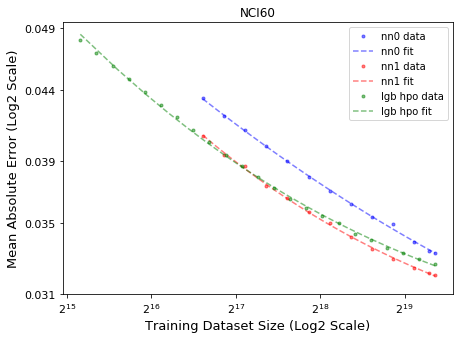

In [67]:
# Reset axes
ax = None
# fit_method = 'old'
fit_method = 'new'

# NN0
if nn0 is not None:
    name = 'nn0'
    color = 'b'
    aa = dfit_nn0
    
    xf = aa['tr_size'].values
    yf = aa['y'].values
    
    if fit_method == 'new':
        cc_nn0 = FitPwrLaw(xf=xf, yf=yf, w=aa['w'].values, **startParams)  # new!
        xf_plot, yf_plot = cc_nn0.calc_fit( x1=xf[0], x2=xf[-1] )
    else:
        # Old fit method (see single single_src.ipynb)  
        prms_nn0 = fit_params(x=xf, y=yf)
        yf_plot = biased_powerlaw(xf, **prms_nn0)
        xf_plot = xf   
    
    ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color=color, label=f'{name} data')
    ax = lc_plots.plot_lc(x=xf_plot, y=yf_plot, ax=ax, **fit_args, color=color, label=f'{name} fit')

# NN1
if nn1 is not None:
    name = 'nn1'
    color = 'r'
    aa = dfit_nn1
    
    xf = aa['tr_size'].values
    yf = aa['y'].values
    
    if fit_method == 'new':
        cc_nn1 = FitPwrLaw(xf=xf, yf=yf, w=aa['w'].values, **startParams)  # new!
        xf_plot, yf_plot = cc_nn1.calc_fit( x1=xf[0], x2=xf[-1] )
    else:
        # Old fit method (see single single_src.ipynb) 
        prms_nn1 = fit_params(x=xf, y=yf)
        yf_plot = biased_powerlaw(xf, **prms_nn1)
        xf_plot = xf
    
    ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color=color, label=f'{name} data')
    ax = lc_plots.plot_lc(x=xf_plot, y=yf_plot, ax=ax, **fit_args, color=color, label=f'{name} fit')

# LGB HPO
if lgb_hpo is not None:
    lgb = dfit_lgb_hpo
    name = 'lgb hpo'
    color = 'g'
    aa = dfit_lgb_hpo
    
    xf = aa['tr_size'].values
    yf = aa['y'].values
    
    if fit_method == 'new':
        cc_lgb = FitPwrLaw(xf=xf, yf=yf, w=aa['w'].values, **startParams)  # new!
        xf_plot, yf_plot = cc_lgb.calc_fit( x1=xf[0], x2=xf[-1] )
        cc_lgb_hpo = cc_lgb
    else:    
        # Old fit method (see single single_src.ipynb) 
        prms_lgb_hpo = fit_params(x=xf, y=yf)
        yf_plot = biased_powerlaw(xf, **prms_lgb_hpo)
        xf_plot = xf  
    
    ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color=color, label=f'{name} data')
    ax = lc_plots.plot_lc(x=xf_plot, y=yf_plot, ax=ax, **fit_args, color=color, label=f'{name} fit')
    del lgb
    
# LGB Default
if lgb_dft is not None:
    lgb = dfit_lgb_dft
    name = 'lgb dflt'
    color = 'm'
    aa = dfit_lgb_dft
    
    xf = aa['tr_size'].values
    yf = aa['y'].values
    
    if fit_method == 'new':
        cc_lgb = FitPwrLaw(xf=xf, yf=yf, w=aa['w'].values, **startParams)  # new!
        xf_plot, yf_plot = cc_lgb.calc_fit( x1=xf[0], x2=xf[-1] )
        cc_lgb_dft = cc_lgb
    else:
        # Old fit method (see single single_src.ipynb)  
        prms_lgb_dft = fit_params(x=xf, y=yf)
        yf_plot = biased_powerlaw(xf, **prms_lgb_dft)
        xf_plot = xf
    
    ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color=color, label=f'{name} data')
    ax = lc_plots.plot_lc(x=xf_plot, y=yf_plot, ax=ax, **fit_args, color=color, label=f'{name} fit')
    del lgb

ax.set_title(f'{src}')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

In [68]:
display(cc_nn0.coefs)
display(cc_nn1.coefs)
display(cc_lgb_hpo.coefs)
display(cc_lgb_dft.coefs)

,coef,est,se,t_val,p_val
0,a,0.939084,0.420670,2.232354,0.049644
1,b,-0.326913,0.047189,-6.927702,0.000041
2,c,0.021583,0.002205,9.787097,0.000002


,coef,est,se,t_val,p_val
0,a,5.398896,1.901360,2.839492,1.756369e-02
1,b,-0.517387,0.033341,-15.517831,2.522199e-08
2,c,0.026764,0.000520,51.466646,1.854988e-13


,coef,est,se,t_val,p_val
0,a,2.894316,0.462544,6.257378,4.134292e-06
1,b,-0.466910,0.016219,-28.787750,9.403350e-18
2,c,0.027042,0.000349,77.403354,2.932833e-26


NameError: name 'cc_lgb_dft' is not defined

In [24]:
display(prms_nn0)
display(prms_nn1)
display(prms_lgb_hpo)
display(prms_lgb_dft)

NameError: name 'prms_nn0' is not defined

In [37]:
dfs = []

In [38]:
aa = nn0
aa['std'] = aa['score']
aa['min'] = aa['score']
aa['max'] = aa['score']
aa = aa.groupby(['tr_size']).agg({'score': 'median', 'std': 'std', 'min': 'min', 'max': 'max'}).reset_index()
score_name = f'{met}_median'
aa = aa.rename(columns={'score': score_name})
aa['%'] = aa['std']/aa[score_name]
aa

TypeError: 'NoneType' object is not subscriptable

In [34]:
aa = nn1
aa['std'] = aa['score']
aa['min'] = aa['score']
aa['max'] = aa['score']
aa = aa.groupby(['tr_size']).agg({'score': 'median', 'std': 'std', 'min': 'min', 'max': 'max'}).reset_index()
score_name = f'{met}_median'
aa = aa.rename(columns={'score': score_name})
aa['%'] = aa['std']/aa[score_name]
aa

,tr_size,mean_absolute_error_median,std,min,max,%
0,10000,0.054301,0.000985,0.053034,0.057596,0.018148
1,11360,0.053336,0.002441,0.052115,0.070701,0.045770
2,12906,0.053120,0.001205,0.051359,0.057344,0.022689
3,14661,0.052788,0.001788,0.051397,0.063795,0.033863
4,16656,0.051766,0.001326,0.050503,0.054988,0.025623
5,18922,0.051566,0.001189,0.049663,0.054252,0.023065
6,21497,0.050795,0.001048,0.049049,0.053064,0.020624
7,24422,0.050494,0.001061,0.048562,0.052657,0.021010
8,27744,0.049594,0.000969,0.047705,0.051311,0.019532
9,31519,0.048912,0.000825,0.047149,0.050656,0.016858


In [35]:
aa = lgb_hpo
aa['std'] = aa['score']
aa['min'] = aa['score']
aa['max'] = aa['score']
aa = aa.groupby(['tr_size']).agg({'score': 'median', 'std': 'std', 'min': 'min', 'max': 'max'}).reset_index()
score_name = f'{met}_median'
aa = aa.rename(columns={'score': score_name})
aa['%'] = aa['std']/aa[score_name]
aa

,tr_size,mean_absolute_error_median,std,min,max,%
0,1024,0.390156,0.314117,0.000000,0.843854,0.805106
1,1279,0.449052,0.320192,0.000000,0.840160,0.713038
2,1597,0.459144,0.326735,0.000000,0.839861,0.711618
3,1996,0.511869,0.332571,0.008342,0.834656,0.649719
4,2493,0.534985,0.337900,0.007835,0.834006,0.631607
5,3115,0.550209,0.343804,0.007535,0.833260,0.624861
6,3891,0.567000,0.348847,0.007012,0.833055,0.615250
7,4861,0.599974,0.353727,0.006549,0.833055,0.589571
8,6072,0.616807,0.358186,0.006159,0.840726,0.580709
9,7586,0.630163,0.362308,0.005914,0.849176,0.574943


In [36]:
aa = lgb_dft
aa['std'] = aa['score']
aa['min'] = aa['score']
aa['max'] = aa['score']
aa = aa.groupby(['tr_size']).agg({'score': 'median', 'std': 'std', 'min': 'min', 'max': 'max'}).reset_index()
score_name = f'{met}_median'
aa = aa.rename(columns={'score': score_name})
aa['%'] = aa['std']/aa[score_name]
aa

,tr_size,mean_absolute_error_median,std,min,max,%
0,1024,0.392024,0.313532,0.000000,0.843923,0.799779
1,1279,0.438107,0.319840,0.000000,0.840384,0.730049
2,1597,0.449346,0.327145,0.000000,0.839241,0.728046
3,1996,0.510822,0.332827,0.008332,0.836137,0.651553
4,2493,0.541039,0.338209,0.007771,0.835106,0.625110
5,3115,0.548043,0.344026,0.007487,0.834154,0.627735
6,3891,0.580052,0.348778,0.006951,0.833322,0.601287
7,4861,0.591953,0.353101,0.006506,0.833154,0.596502
8,6072,0.614625,0.356716,0.006212,0.837216,0.580380
9,7586,0.628004,0.359932,0.006088,0.845051,0.573137


In [29]:
xf = dfit['tr_size'].values
# xe = dext['tr_size'].values
yf = dfit['y'].values
# ye = dext['y'].values

cc = FitPwrLaw(xf=dfit['tr_size'].values, yf=dfit['y'].values, w=dfit['w'].values)
xf_plot, yf_plot = cc.calc_fit( x1=xf[0], x2=xf[-1] )
# xe_plot, ye_plot = cc.calc_fit( x1=xe[0], x2=xe[-1] )

# Reset axes
ax = None

# Raw data
ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color='b', label='dfit data')
# ax = lc_plots.plot_lc(x=xe, y=ye, ax=ax, **pnts_args, color='r', label='dext data')

# Fits
ax = lc_plots.plot_lc(x=xf_plot, y=yf_plot, ax=ax, **fit_args, color='b', label='dfit fit')
# ax = lc_plots.plot_lc(x=xe_plot, y=ye_plot, ax=ax, **fit_args, color='r', label='dext fit')

ax.set_title(f'{src} ~ {model}')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

NameError: name 'dfit' is not defined